# CSGY-6053: Foundations of Data Science Final Project

Group Members : 
- Majid Daliri, md5367
- Affan Arif Khamse, ak10529
- Seeger Zou, jz3714

In [38]:
# similar to homework setting
# set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

np.random.seed(5)

%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [6]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

## Introduction

In this project, our objective is to analyze the California Housing Prices dataset available [here](https://www.kaggle.com/datasets/jl1019/california-house-price-limu?select=test.csv) and apply various analysis methods we learned throughout the semester. We are interested in what factors contribute to a particular property's listed price. Intuitively, we expect that houses with more interior livable area would result in a higher price. Therefore, we revolve our analysis on this question: How does total interior livable area affect the listed price?

Below are detailed description of the dataset we used. There are several challenges we encountered: First of all, the distribution of the prices has a rather high variance. Second, we had hoped the relationship between the total livable area and the listed price would be continuous and linear, but throughout our analysis we opted to try other models instead to show a better fit. Third, we observed that the possible confound variable we selected has little influence on the listed price, our outcome variable. Based on the results and plots of our estimations, we explain why this is the case.

## Dataset

### Source 
This dataset is derived from a popular collection of data known as the "California Housing" dataset. It is hosted on Kaggle and was compiled by user jl1019. The "California Housing" dataset is renowned for its comprehensive inclusion of property attributes along with pricing and locational information, making it an invaluable resource for predictive modeling and real estate market analysis in California.

The dataset is a go-to resource for educators, researchers, and industry professionals who wish to explore and analyze the dynamics of the California real estate market. It offers a detailed snapshot of various housing-related factors including the physical characteristics of properties, their tax assessments, historical sale prices, and geographical details. This rich set of data allows for deep dives into predictive analytics and trend identification within the housing markets across different regions in California.

This detailed dataset helps in understanding the impact of various features like school ratings, property type, and amenities on housing prices in California. It is a prime example of how real-world data can be leveraged to gain insights into market behaviors and property valuation.

### Features Overview:
Chose test.csv from [here](https://www.kaggle.com/datasets/jl1019/california-house-price-limu?select=test.csv)

- **Id**: Unique identifier for each property.
- **Address**: Street address of the property.
- **Summary**: Brief description of the property.
- **Type**: Type of the dwelling (e.g., single-family home, condo).
- **Year Built**: Year when the property was constructed.
- **Heating**: Type of heating system installed in the property.
- **Cooling**: Type of cooling system installed in the property.
- **Parking**: Types of parking available with the property.
- **Lot**: Size of the lot on which the property is situated.
- **Bedrooms**: Number of bedrooms.
- **Bathrooms**: Total number of bathrooms.
- **Full Bathrooms**: Number of full bathrooms.
- **Total Interior Livable Area**: Interior area that is livable, measured in square feet.
- **Total Spaces**: Total number of parking spaces available.
- **Garage Spaces**: Number of garage spaces.
- **Region**: Region in California where the property is located.
- **Elementary School** and related details: Information about nearby elementary schools.
- **Middle School** and related details: Information about nearby middle schools.
- **High School** and related details: Information about nearby high schools.
- **Flooring**, **Heating features**, **Cooling features**: Details about the flooring, heating, and cooling features.
- **Appliances included**, **Laundry features**, **Parking features**: Details about appliances, laundry, and parking included with the property.
- **Tax Assessed Value**, **Annual Tax Amount**: Financial details related to property tax.
- **Listed On**, **Listed Price**: Details about when and for how much the property was listed.
- **Last Sold On**, **Last Sold Price**: Most recent sale details.
- **City**, **Zip**, **State**: Location details of the property.


In [3]:
df = pd.read_csv("test.csv", header=0)

df.head()

,Unnamed: 0,Id,Address,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,22417,69856,5222 Verdura Ave,"Welcome to 5222 Verdura Ave, near the very pop...",SingleFamily,1952.0,"Central, Fireplace(s)",Central Air,"Driveway Level, Garage",5323.0,...,"Driveway Level, Garage",700000.0,8917.0,2021-01-13,790000.0,2007-02-16,715000.0,Lakewood,90712,CA
1,3546,50985,6965 Casa Del Sol Way,"6965 Casa Del Sol Way, Sacramento, CA 95828 is...",SingleFamily,1979.0,Central,Central Air,"Garage, Garage - Attached, Covered",6956.0,...,"Garage, Garage - Attached, Covered",137442.0,1764.0,2020-12-19,349900.0,2020-09-04,230000.0,Sacramento,95828,CA
2,1044,48483,1083 Pacheco St,Golden Gate Heights modern masterpiece w/ pano...,SingleFamily,1966.0,Central,Central Air,"Attached, Garage Door Opener, Interior Access,...",3236.0,...,"Attached, Garage Door Opener, Interior Access,...",2907000.0,35562.0,2020-12-02,2875000.0,2019-03-26,2850000.0,San Francisco,94116,CA
3,20205,67644,2115 Washington Way,Great start home for first time home buyer! 3-...,SingleFamily,1972.0,Forced Air,Central Air,Attached,6098.4,...,Attached,175713.0,2341.0,2021-01-12,399000.0,2010-07-14,150000.0,Antioch,94509,CA
4,13710,61149,8300 Juglans Dr,Welcome to 8300 Juglans Dr! This beautiful ho...,SingleFamily,1979.0,"Natural Gas, Central","Central Air, Ceiling Fan(s)","Garage, Garage - Detached, Covered",8276.0,...,"Garage, Garage - Detached, Covered",175713.0,2184.0,2020-12-29,408888.0,2011-06-17,150000.0,Orangevale,95662,CA


## Identify a Question/Estimand

How does total interior livable area affect the listed housing price?

## Causal Model

![](DAG.png)

The diagram consists of the following variables,

*I*: Total interior livable area

*B*: Number of bedrooms

*P*: listed price

For future reference, we will be using these variables.

In [5]:
# adjusting the data accordingly, get rid of unused variables
selected_columns = ['Total interior livable area', 'Bedrooms', 'Listed Price']
df = df[selected_columns]

# convert all to numeric, drop rows with missing values
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df = df.dropna()

df.head(), df.shape

(   Total interior livable area  Bedrooms  Listed Price
 0                       1953.0       4.0      790000.0
 1                       1456.0       3.0      349900.0
 2                       2795.0       4.0     2875000.0
 3                       1288.0       3.0      399000.0
 4                       1129.0       3.0      408888.0,
 (965, 3))

## Prior predictive simulations

At first, we choose a simple linear regression model for this relationship, since we expect the problem to be regressive in nature. Initially we did not try to use higher complexity models as they might not be appropriate for this relationship, and too much parameters could lead to potential overfitting that would require regularization techniques to optimize.

In our prior predictive simulations, we do the following:

1. We standardize the variables

2. We observe our data distributions via scatter plot and kdeplots

3. We setup reasonable priors for both the total and direct effect models and do prior predictive checks

In [11]:
df.loc[:, "I"] = standardize(df["Total interior livable area"])

# generally output not normalized
df.loc[:, "P"] = standardize(df["Listed Price"])
df.head()

,Total interior livable area,Bedrooms,Listed Price,I,P
0,1953.0,4.0,790000.0,-0.188767,-0.216679
1,1456.0,3.0,349900.0,-0.650790,-0.643762
2,2795.0,4.0,2875000.0,0.593977,1.806649
3,1288.0,3.0,399000.0,-0.806967,-0.596114
4,1129.0,3.0,408888.0,-0.954777,-0.586518


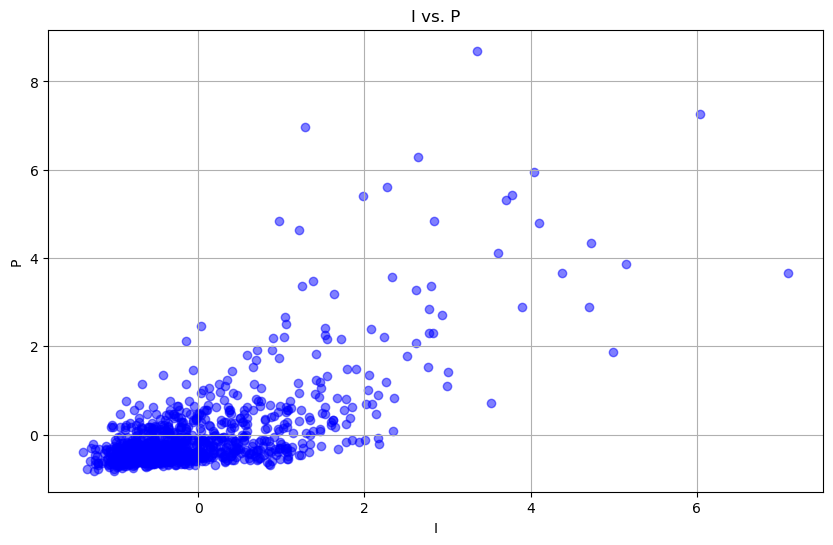

In [121]:
X = df['I'].values  # Assuming this is the normalized version
Y = df['P'].values

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, color='blue')  # Adjust alpha for point transparency
plt.title('I vs. P')
plt.xlabel('I')
plt.ylabel('P')
plt.grid(True)
plt.show()

We can see that most of our data points lie in the bottom left, where the price is low and the interior livable area is also small. We observe that in general there is a upper trend, meaning that our hypothesis is likely to be correct. There are a couple of outliers that should be mentioned, notably that the most expensive housing does not have the most interior area, and vice versa. This already suggests that this problem in nature might be more than a linear estimation.

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='P', ylabel='Density'>

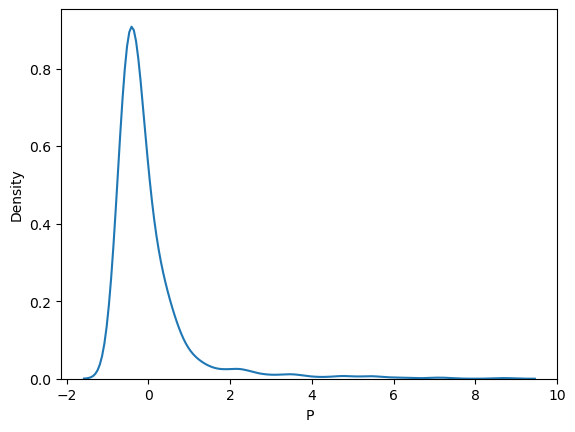

In [49]:
sns.kdeplot(df.P)

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='I', ylabel='Density'>

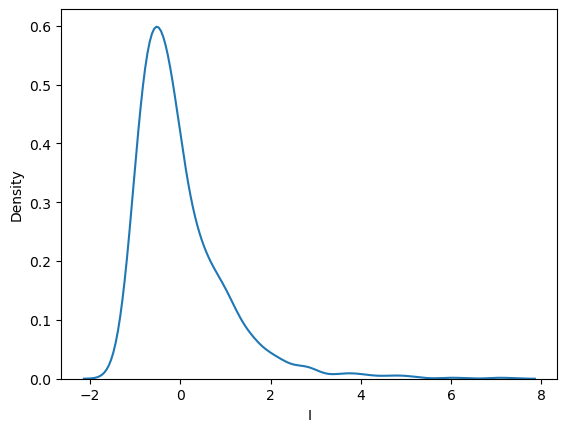

In [111]:
sns.kdeplot(df.I)

The two distributions for *P* and *I* reflects each other, indicating that as *I* increases, *P* also increases. Both have extrema towards the negative side of 0, and most data points lie between -2 and 2. We observe that they also have long tails.

### Total Causal Effect Priors

#### Model

$$\alpha \sim \text{Normal}(0,1)$$  
$${\beta}_I \sim \text{Normal}(0, 1)$$  
$$\sigma \sim \text{Exponential}(1)$$
$$\mu = \alpha + {\beta}_I \times I$$
$$P \sim \text{Normal}(\mu, \sigma)$$
The model structure includes an intercept ($\alpha$), a coefficients (${\beta}_I$ for Interior Area), and a standard deviation term ($\sigma$).

Intercept (a or $\alpha$): Normal distribution centered around 0 with a standard deviation of 1.

Interior Area (bI or ${\beta}_I$): Normal distribution centered around 0 with a standard deviation of 1.

Sigma ($\sigma$): Exponential distribution with a rate of 1.

In [33]:
# simple regression
with pm.Model() as m_predictive_1:
    a= pm.Normal("a", 0, 1)
    bI = pm.Normal("bI", 0, 1)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I
    
    P = pm.Normal("P", mu, sigma, observed=df.P)
    idata_predictive_1 = pm.sample_prior_predictive(random_seed=145)
az.summary(idata_predictive_1)

Sampling: [P, a, bI, sigma]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bI,0.009,0.960,-1.542,1.510,0.044,0.031,483.0,406.0,NaN
a,0.072,0.996,-1.665,1.460,0.043,0.033,531.0,472.0,NaN
sigma,1.030,1.031,0.006,2.409,0.045,0.032,541.0,472.0,NaN


#### Observation:

**Intercept (a):**
Mean: 0.072
Standard Deviation: 0.996
The HDI spans from -1.665 to 1.460, showing significant uncertainty about the intercept. This suggests that without considering I (livable interior area), the base price P can vary widely, indicating that the model with these priors might not be informative enough to pinpoint the base price.


**Coefficient for I (bI):**
Mean: 0.009
Standard Deviation: 0.960
The HDI ranges from -1.542 to 1.510, implying that the effect of I on P is highly uncertain with the current priors.


**Standard Deviation (sigma):**
Mean: 1.030
Standard Deviation: 1.031
The very wide HDI from 0.006 to 2.409 reflects significant uncertainty in the variability of P around the predicted values. This range indicates potential issues with the scale or variance in price not being adequately explained by the interior area with the chosen priors.

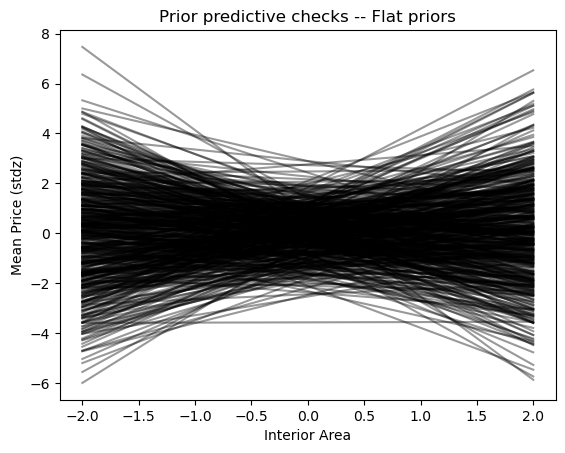

In [40]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 500), dims=["plot_dim"])
prior = idata_predictive_1.prior
y = prior["a"] + prior["bI"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Interior Area")
ax.set_ylabel("Mean Price (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

This distribution seems unrealistic as it is too permissive. First of all, the data range for the price is from 8 to -6 roughly, which is not what we observed in the data. We can make a better prior for this model.

#### Revised Model with Updated Priors:
With updated priors, the model aims to better capture the typical scales and relationships expected in real-world data:


$\alpha \sim \text{Normal}(3.2,1)$  
${\beta}I \sim \text{Normal}(1.5, 0.6)$  
$\sigma \sim \text{Exponential}(1)$  

The model structure includes an intercept ($\alpha$), a coefficients (${\beta}I$ for Interior Area), and a standard deviation term ($\sigma$).

Intercept (a or $\alpha$): Normal distribution centered around 3.2 with a standard deviation of 1.

Interior Area (bI or ${\beta}I$): Normal distribution centered around 1.5 with a standard deviation of 0.6.

Sigma ($\sigma$): Exponential distribution with a rate of 1.


In [107]:
with pm.Model() as m_predictive_2:
    a= pm.Normal("a", 3.2, 1)
    bI = pm.Normal("bI", 1.5, 0.6)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I
    
    P = pm.Normal("P", mu, sigma, observed=df.P)
    idata_predictive_2 = pm.sample_prior_predictive(random_seed=145)
az.summary(idata_predictive_2)

Sampling: [P, a, bI, sigma]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bI,1.505,0.576,0.575,2.406,0.026,0.019,483.0,406.0,NaN
a,3.272,0.996,1.535,4.660,0.043,0.031,531.0,472.0,NaN
sigma,1.030,1.031,0.006,2.409,0.045,0.032,541.0,472.0,NaN


#### Observations

**Intercept (a):**
Mean: 3.272
Standard Deviation: 0.996
The HDI from 1.535 to 4.660 suggests a more narrowed and realistic range for the base price P.


**Coefficient for I (bI):**
Mean: 1.505
Standard Deviation: 0.576
The HDI from 0.575 to 2.406 now indicates a stronger and more defined positive effect of I on P. This shift suggests that as the livable interior area increases, the price is expected to increase significantly, aligning more closely with real-world expectations about property pricing.


**Standard Deviation (sigma):**
Remains largely unchanged in terms of the distribution, maintaining a mean of 1.030 and a similar HDI. The consistency in sigma across both models suggests that while the effect and base price estimates have been refined, the overall variability in price prediction around the model's expected value remains a challenge. 

This uncertainty in sigma is largely due to the fact the price of house depends upon many other feature/variable like location, amenities, etc. For which we would required more complex model that can integrate a broader range of influences to reduce prediction uncertainty

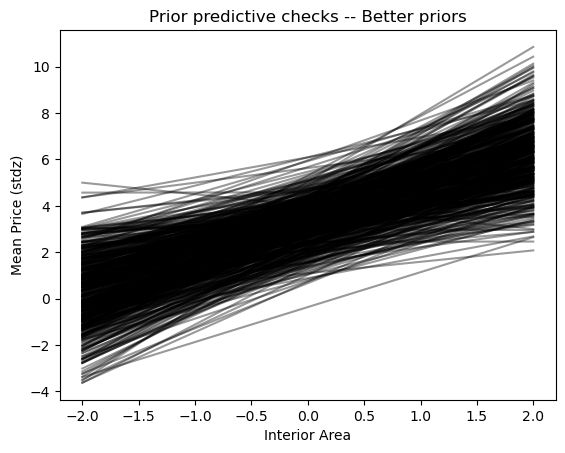

In [108]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 500), dims=["plot_dim"])
prior = idata_predictive_2.prior
y = prior["a"] + prior["bI"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Interior Area")
ax.set_ylabel("Mean Price (stdz)")
ax.set_title("Prior predictive checks -- Better priors");

This prior seems better. What's more, we reflect the trend that we observed in the data distribution: we should expect P to be higher when I is higher.

### Direct Causal Effect Priors

#### Model

$\alpha \sim \text{Normal}(3.2,1)$  
${\beta}I \sim \text{Normal}(1.5, 0.6)$  
${\beta}B \sim \text{Normal}(0, 0.3)$

${\sigma} \sim \text{Exponential}(1)$  

The model structure includes an intercept (a), two coefficients (bI for Interior Area, bB for Bedrooms), and a standard deviation term (sigma).
The priors chosen for a, bI, bB, and sigma appear reasonable based on their distributions:

Intercept (a): Normal distribution centered around 3.2 with a standard deviation of 1.

Interior Area (bI): Normal distribution centered around 1.5 with a standard deviation of 0.6.

Bedrooms (bB): Normal distribution centered at 0 with a standard deviation of 0.3, indicating uncertainty about its effect direction.

Sigma: Exponential distribution with a rate of 1.

In [139]:
with pm.Model() as m_predictive_3:
    a= pm.Normal("a", 3.2, 1)
    bI = pm.Normal("bI", 1.5, 0.6)
    bB = pm.Normal("bB", 0, 0.3)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I + bB * df.Bedrooms
    
    P = pm.Normal("P", mu, sigma, observed=df.P)
    idata_predictive_3 = pm.sample_prior_predictive(random_seed=145)
az.summary(idata_predictive_3)

Sampling: [P, a, bB, bI, sigma]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bI,1.505,0.576,0.575,2.406,0.026,0.019,483.0,406.0,NaN
bB,0.021,0.299,-0.499,0.438,0.013,0.010,531.0,472.0,NaN
sigma,1.030,1.031,0.006,2.409,0.045,0.032,541.0,472.0,NaN
a,3.231,0.987,1.837,4.896,0.049,0.035,418.0,335.0,NaN


#### Observation:
The summary statistics provide essential details for each parameter:

Interior Area (bI): The mean is 1.505 with an HDI between 0.575 and 2.406, indicating a significant positive effect. This suggests that as the livable interior area increases, the price is expected to increase significantly, aligning more closely with real-world expectations about property pricing.

Bedrooms (bB): The mean is 0.021, but the HDI is very wide from -0.499 to 0.438, indicating substantial uncertainty about the effect of bedrooms on price.

Intercept (a): The HDI for the intercept spans from 1.837 to 4.896, showing a refined range for the base price.

Sigma: Consistent with previous models, sigma has a high mean and wide HDI, suggesting high variability.

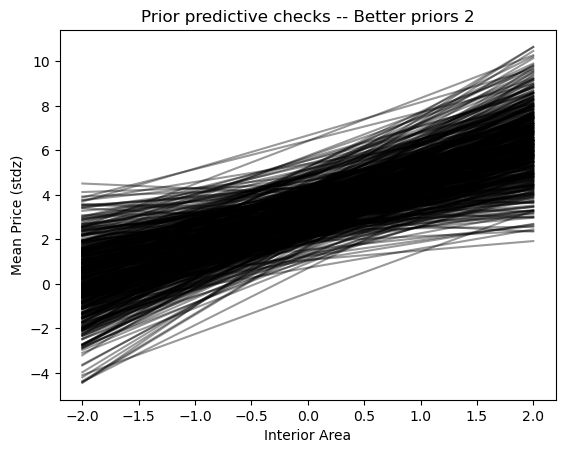

In [140]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 500), dims=["plot_dim"])
prior = idata_predictive_3.prior
y = prior["a"] + prior["bI"] * x + prior["bB"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Interior Area")
ax.set_ylabel("Mean Price (stdz)")
ax.set_title("Prior predictive checks -- Better priors 2");

We adjusted the priors since we are introducing a new variable. The top right part should be more sparse, as we saw in the scatter plot, but it should give us an acceptable estimate.

## Analyze the Real Data

### Total Causal Effect

##### Model:

$\alpha \sim \text{Normal}(3.2,1)$  
${\beta}I \sim \text{Normal}(1.5, 0.6)$  
$\sigma \sim \text{Exponential}(1)$  

The model structure includes an intercept ($\alpha$), a coefficients (${\beta}I$ for Interior Area), and a standard deviation term ($\sigma$).

Intercept (a or $\alpha$): Normal distribution centered around 3.2 with a standard deviation of 1.

Interior Area (bI or ${\beta}I$): Normal distribution centered around 1.5 with a standard deviation of 0.6.

Sigma ($\sigma$): Exponential distribution with a rate of 1.


In [122]:
with pm.Model() as m_total:
    a= pm.Normal("a", 3.2, 1)
    bI = pm.Normal("bI", 1.5, 0.6)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I
    
    P = pm.Normal("P", mu, sigma, observed=df.P)
    idata_total = pm.sample(tune=3000,
                            random_seed=145,
                            idata_kwargs={"log_likelihood":True}
                           )
az.summary(idata_total)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bI, sigma]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.024,-0.035,0.042,0.0,0.001,3214.0,1610.0,1.0
bI,0.687,0.024,0.650,0.725,0.0,0.000,2613.0,1380.0,1.0
sigma,0.729,0.016,0.703,0.754,0.0,0.000,2464.0,1282.0,1.0



#### Observation:

Intercept (a):
Mean: 0.002
Standard Deviation: 0.024
HDI (5.5% to 94.5%): -0.035 to 0.042
The intercept is effectively zero within the context of the data scale, suggesting that the base price (when Interior Area is zero) is practically negligible.

Coefficient for Interior Area (bI):
Mean: 0.687
Standard Deviation: 0.024
HDI (5.5% to 94.5%): 0.650 to 0.725
This result shows a clear and positive effect of interior area on house prices, with a narrow high-density interval indicating precise estimates and high confidence in this effect.

Standard Deviation ($\sigma\$):
Mean: 0.729
Standard Deviation: 0.016
HDI (5.5% to 94.5%): 0.703 to 0.754

The model's estimated variability in price predictions is reasonably low, showing that the model fits the data closely, and most of the price variation can be reliably predicted by the interior area.

Sampling: [P]


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='P'>

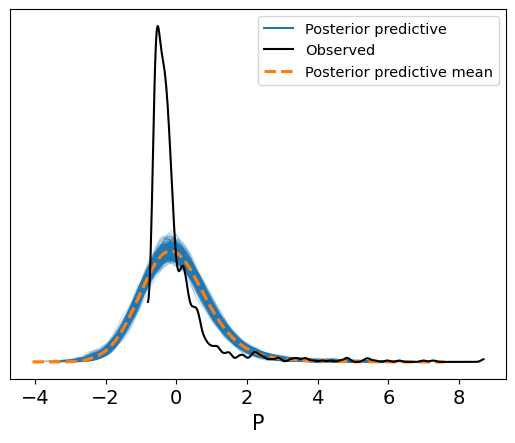

In [126]:
with m_total:
    pm.sample_posterior_predictive(idata_total, extend_inferencedata=True, random_seed=145)
az.plot_ppc(idata_total, num_pp_samples=500)

We see that while the central tendency of our model roughly aligns with the observed data, it does not capture the extreme values very well. There is a large mismatch and as we will discuss later, brings a couple of adjustments to our attention.

### Direct Causal Effect

#### Model

$\alpha \sim \text{Normal}(5.4,0.5)$  
${\beta}I \sim \text{Normal}(1.5, 0.6)$  
${\beta}B \sim \text{Normal}(0, 0.3)$

$\sigma \sim \text{Exponential}(1)$  

The model structure includes an intercept (a), two coefficients (bI for Interior Area, bB for Bedrooms), and a standard deviation term (sigma).
The priors chosen for a, bI, bB, and sigma appear reasonable based on their distributions:

Intercept (a): Normal distribution centered around 5.4 with a standard deviation of 0.5.

Interior Area (bI): Normal distribution centered around 1.5 with a standard deviation of 0.6.

Bedrooms (bB): Normal distribution centered at 0 with a standard deviation of 0.3, indicating uncertainty about its effect direction.

Sigma: Exponential distribution with a rate of 1.

In [131]:
with pm.Model() as m_direct:
    a= pm.Normal("a", 5.4, 0.5)
    bI = pm.Normal("bI", 1.5, 0.6)
    bB = pm.Normal("bB", 0, 0.3)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I + bB * df.Bedrooms
    
    P = pm.Normal("P", mu, sigma, observed=df.P)
    idata_direct = pm.sample(tune=3000,
                             random_seed=145,
                            idata_kwargs={"log_likelihood":True}
                            )
az.summary(idata_direct)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bI, bB, sigma]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.023,0.125,0.792,1.200,0.006,0.004,494.0,695.0,1.01
bI,0.871,0.032,0.820,0.923,0.001,0.001,642.0,1122.0,1.00
bB,-0.289,0.035,-0.347,-0.234,0.002,0.001,494.0,679.0,1.01
sigma,0.718,0.017,0.691,0.746,0.000,0.000,1397.0,1171.0,1.00


#### Observations:

**Intercept (a):**
Mean: 1.023
Standard Deviation: 0.125
HDI (5.5% to 94.5%): 0.792 to 1.200

The intercept, which represents the baseline price when both interior area and number of bedrooms are zero, is significantly positive but lower than the prior mean of 5.4. This might suggest that other factors in dataset impacts the price predictions.

**Coefficient for Interior Area (bI):**
Mean: 0.871
Standard Deviation: 0.032
HDI: 0.820 to 0.923

This result shows a strong positive effect of interior area(I) on house prices(P), and the relatively narrow HDI indicates high confidence in this effect. The value suggests that increases in interior area lead to substantial increases in house price, *confirming the importance of this variable*.

**Coefficient for Bedrooms (bB):**
Mean: -0.289
Standard Deviation: 0.035
HDI: -0.347 to -0.234

The effect of the number of bedrooms on house prices is negative, contrary to common expectations that more bedrooms typically increase house value. 

This suggest a potential confounding factor where larger numbers of bedrooms within the same interior area might indicate smaller room sizes or less desirable layout configurations.

**Standard Deviation ($\sigma\$):**
Mean: 0.718
Standard Deviation: 0.017
HDI: 0.691 to 0.746

The relatively low value of sigma suggests that the model explains a significant portion of the variability in house prices, indicating a good fit of the model to the observed data.


Sampling: [P]


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='P'>

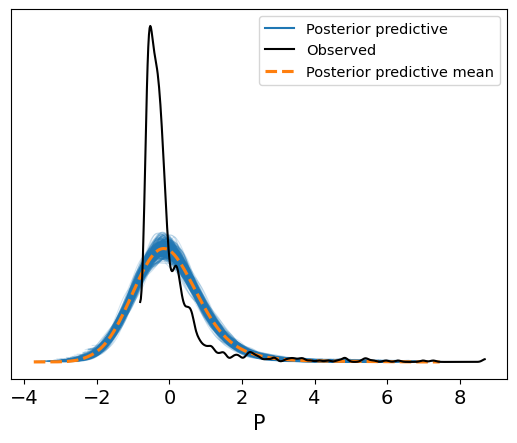

In [132]:
with m_direct:
    pm.sample_posterior_predictive(idata_direct, extend_inferencedata=True, random_seed=145)
az.plot_ppc(idata_direct, num_pp_samples=500)

More or less the same here as the total effect model, we can see that the distribution is not strictly linear. We point out problems that we ran into below and provide fixes in an attempt to provide a better result.

### Student T - Direct Causal Effect
**Why we use a Student-T Distribution?**

- Robustness to Outliers: The Student-T distribution is known for being more robust to outliers in the data compared to the normal distribution.
- Heavier Tails: It accommodates more probability in the tails than a normal distribution, which can be more realistic for financial data like house prices that can exhibit heavy-tailed behavior.
- Flexibility: The nu parameter (degrees of freedom) allows the model to adjust the kurtosis of the distribution. As nu increases, the Student-T distribution approaches a normal distribution, providing flexibility in modeling the data distribution.

#### Model:

$\alpha \sim \text{Normal}(5.4,0.5)$  
${\beta}I \sim \text{Normal}(1.5, 0.6)$  
${\beta}B \sim \text{Normal}(0, 0.3)$
$\sigma \sim \text{Exponential}(1)$  

The model structure includes an intercept (a), two coefficients (bI for Interior Area, bB for Bedrooms), and a standard deviation term (sigma).
The priors chosen for a, bI, bB, and sigma appear reasonable based on their distributions:

Intercept (a): Normal distribution centered around 5.4 with a standard deviation of 0.5.

Interior Area (bI): Normal distribution centered around 1.5 with a standard deviation of 0.6.

Bedrooms (bB): Normal distribution centered at 0 with a standard deviation of 0.3, indicating uncertainty about its effect direction.

Sigma: Exponential distribution with a rate of 1.

The difference between the observed and predicted values showed that the original model wasn't capturing the data well. This was likely because of non-linear relationships, changes in the spread of data, and outliers impacting the results too much.

To fix this, we applied a log transformation to the 'Listed Price'. This helps by making the distribution of prices more normal by reducing the effect of very high or very low prices, and making the data easier to analyze with simple models.

In [141]:
df.loc[:, "logP"] = standardize(np.log(df["Listed Price"]))
df.head()

,Total interior livable area,Bedrooms,Listed Price,I,P,logP
0,1953.0,4.0,790000.0,-0.188767,-0.216679,0.020018
1,1456.0,3.0,349900.0,-0.650790,-0.643762,-1.231350
2,2795.0,4.0,2875000.0,0.593977,1.806649,2.004932
3,1288.0,3.0,399000.0,-0.806967,-0.596114,-1.029575
4,1129.0,3.0,408888.0,-0.954777,-0.586518,-0.991960


In [155]:
with pm.Model() as m_direct_2:
    a= pm.Normal("a", 5.4, 0.5) # should this be neg
    bI = pm.Normal("bI", 1.5, 0.6)
    bB = pm.Normal("bB", 0, 0.3)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I + bB * df.Bedrooms
    
    P = pm.StudentT("P", nu=15, mu=mu, sigma=sigma, observed=df.logP)
    idata_direct_2 = pm.sample(tune=3000,
                             random_seed=145,
                            idata_kwargs={"log_likelihood":True}
                            )
az.summary(idata_direct_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bI, bB, sigma]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 44 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.783,0.138,0.564,0.994,0.006,0.004,590.0,798.0,1.01
bI,0.792,0.036,0.736,0.850,0.001,0.001,659.0,935.0,1.01
bB,-0.224,0.039,-0.280,-0.159,0.002,0.001,591.0,781.0,1.01
sigma,0.720,0.018,0.691,0.747,0.000,0.000,1247.0,1228.0,1.00


**Intercept (a):**
Mean: 0.783
Standard Deviation: 0.138
HDI: 0.564 to 0.994

Indicates that the expected log price when other predictors are zero is significantly above zero.

**Coefficient for Interior Area (bI):**
Mean: 0.792
Standard Deviation: 0.036
HDI: 0.736 to 0.850

Suggests a strong positive effect of interior area on the log-transformed price, confirming that as the area increases, so does the price, logarithmically.

**Coefficient for Bedrooms (bB):**
Mean: -0.224
Standard Deviation: 0.039
HDI: -0.280 to -0.159

Indicates a negative effect of the number of bedrooms on log price, which could suggest that within the ranges of I controlled for, additional bedrooms may not increase the price as might be expected. This could be reflective of market preferences(in california) where additional bedrooms within the same interior space might imply smaller rooms overall.

**Sigma ($\sigma\$):**
Mean: 0.720
Standard Deviation: 0.018
HDI: 0.691 to 0.747

Shows the model’s estimation of variability around the predicted log price is well-defined and not excessively wide, indicating a good fit.

Sampling: [P]


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='P'>

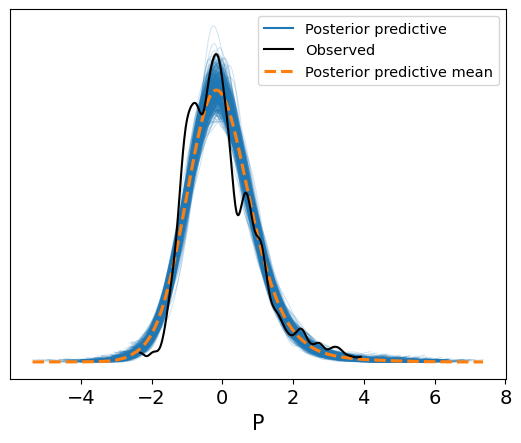

In [156]:
with m_direct_2:
    pm.sample_posterior_predictive(idata_direct_2, extend_inferencedata=True, random_seed=145)
az.plot_ppc(idata_direct_2, num_pp_samples=500)

This is a much better match than the previous attempts. This reinforces the idea of using log transformation on the listed prices to better reflect our distribution. We see that having the nu parameter (the degrees of freedom) also played a part in controlling the extrema to our desired value.

### Polynomial Model

Polynomial models are beneficial because they can capture non-linear relationships between variables, which linear models might miss.

#### Model:

$\alpha \sim \text{Normal}(5.4,0.5)$  
${\beta}I \sim \text{Normal}(1.5, 0.6)$  
${\beta}\text{I2} \sim \text{Normal}(1.5, 0.6)$  
${\beta}B \sim \text{Normal}(0, 0.3)$

$\sigma \sim \text{Exponential}(1)$ 


The model structure includes an intercept (a), three coefficients (bI for Interior Area, bI2 for Quadratic Coefficient for Interior Area ,bB for Bedrooms), and a standard deviation term (sigma).
The priors chosen for a, bI, bI2 ,bB, and sigma appear reasonable based on their distributions:

Intercept (a): Normal distribution centered around 5.4 with a standard deviation of 0.5.

Interior Area (bI): Measures the direct linear impact of interior area on the log-transformed price. Normal distribution centered around 1.5 with a standard deviation of 0.6.

Quadratic Coefficient for Interior Area (bI2): Captures the non-linear effect of interior area on price. Normal distribution centered around 1.5 with a standard deviation of 0.6.

Bedrooms (bB): Estimate the impact of the number of bedrooms on log price, independent of area. Normal distribution centered at 0 with a standard deviation of 0.3, indicating uncertainty about its effect direction.

Sigma: Represents the variability of log prices around the predicted mean (μ). Exponential distribution with a rate of 1.


In [159]:
with pm.Model() as m_direct_3:
    a= pm.Normal("a", 5.4, 0.5)
    bI = pm.Normal("bI", 1.5, 0.6)
    bI2 = pm.Normal("bI2", 1.5, 0.6)
    bB = pm.Normal("bB", 0, 0.3)
    sigma = pm.Exponential("sigma", 1)

    mu =  a + bI * df.I + bB * df.Bedrooms + bI2 * df.I**2
    
    P = pm.Normal("P", mu, sigma, observed=df.logP)
    idata_direct_3 = pm.sample(tune=3000,
                             random_seed=145,
                            idata_kwargs={"log_likelihood":True}
                            )
az.summary(idata_direct_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bI, bI2, bB, sigma]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 54 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.931,0.140,0.696,1.144,0.005,0.004,747.0,1150.0,1.0
bI,0.887,0.047,0.809,0.960,0.002,0.001,736.0,849.0,1.0
bI2,-0.035,0.012,-0.052,-0.015,0.000,0.000,1050.0,965.0,1.0
bB,-0.253,0.038,-0.311,-0.189,0.001,0.001,760.0,1072.0,1.0
sigma,0.759,0.017,0.731,0.784,0.000,0.000,1215.0,1221.0,1.0


#### Observation:

**Intercept (a):**
Mean: 0.931
Standard Deviation: 0.140
HDI: 0.696 to 1.144

Indicates a substantial positive baseline log price, which sets a meaningful intercept for the price predictions.

**Coefficient for Interior Area (bI):**
Mean: 0.887
Standard Deviation: 0.047
HDI: 0.809 to 0.960

Shows a significant positive linear effect of interior area on price, suggesting that as the area increases, so does the price in a linear fashion.

**Quadratic Coefficient for Interior Area (bI2):**
Mean: -0.035
Standard Deviation: 0.012
HDI: -0.052 to -0.015

This negative value indicates that the effect of increasing interior area on price growth diminishes at higher levels of area. This is usually observed in real estate where, beyond a certain point, additional space does not add as much value due to practical utility limitations.

**Coefficient for Bedrooms (bB):**
Mean: -0.253
Standard Deviation: 0.038
HDI: -0.311 to -0.189

Continues to show a negative effect, suggesting that additional bedrooms within the same interior space might reduce the value, possibly due to smaller room sizes or less efficient use of space.

**Standard Deviation (sigma):**
Mean: 0.759
Standard Deviation: 0.017
HDI: 0.731 to 0.784

Indicates the model's estimation of the variability around the predicted log prices is slightly larger than in previous models, possibly due to the introduction of the quadratic term.

Sampling: [P]


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='P'>

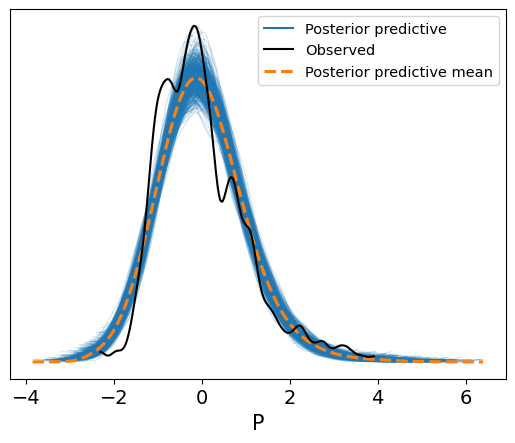

In [160]:
with m_direct_3:
    pm.sample_posterior_predictive(idata_direct_3, extend_inferencedata=True, random_seed=145)
az.plot_ppc(idata_direct_3, num_pp_samples=500)

The distribution we get here is quite similar to the one from the StudentT model, both estimating the direct effect. 

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bI'}>, <Axes: title={'center': 'bI'}>],
       [<Axes: title={'center': 'bI2'}>, <Axes: title={'center': 'bI2'}>],
       [<Axes: title={'center': 'bB'}>, <Axes: title={'center': 'bB'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

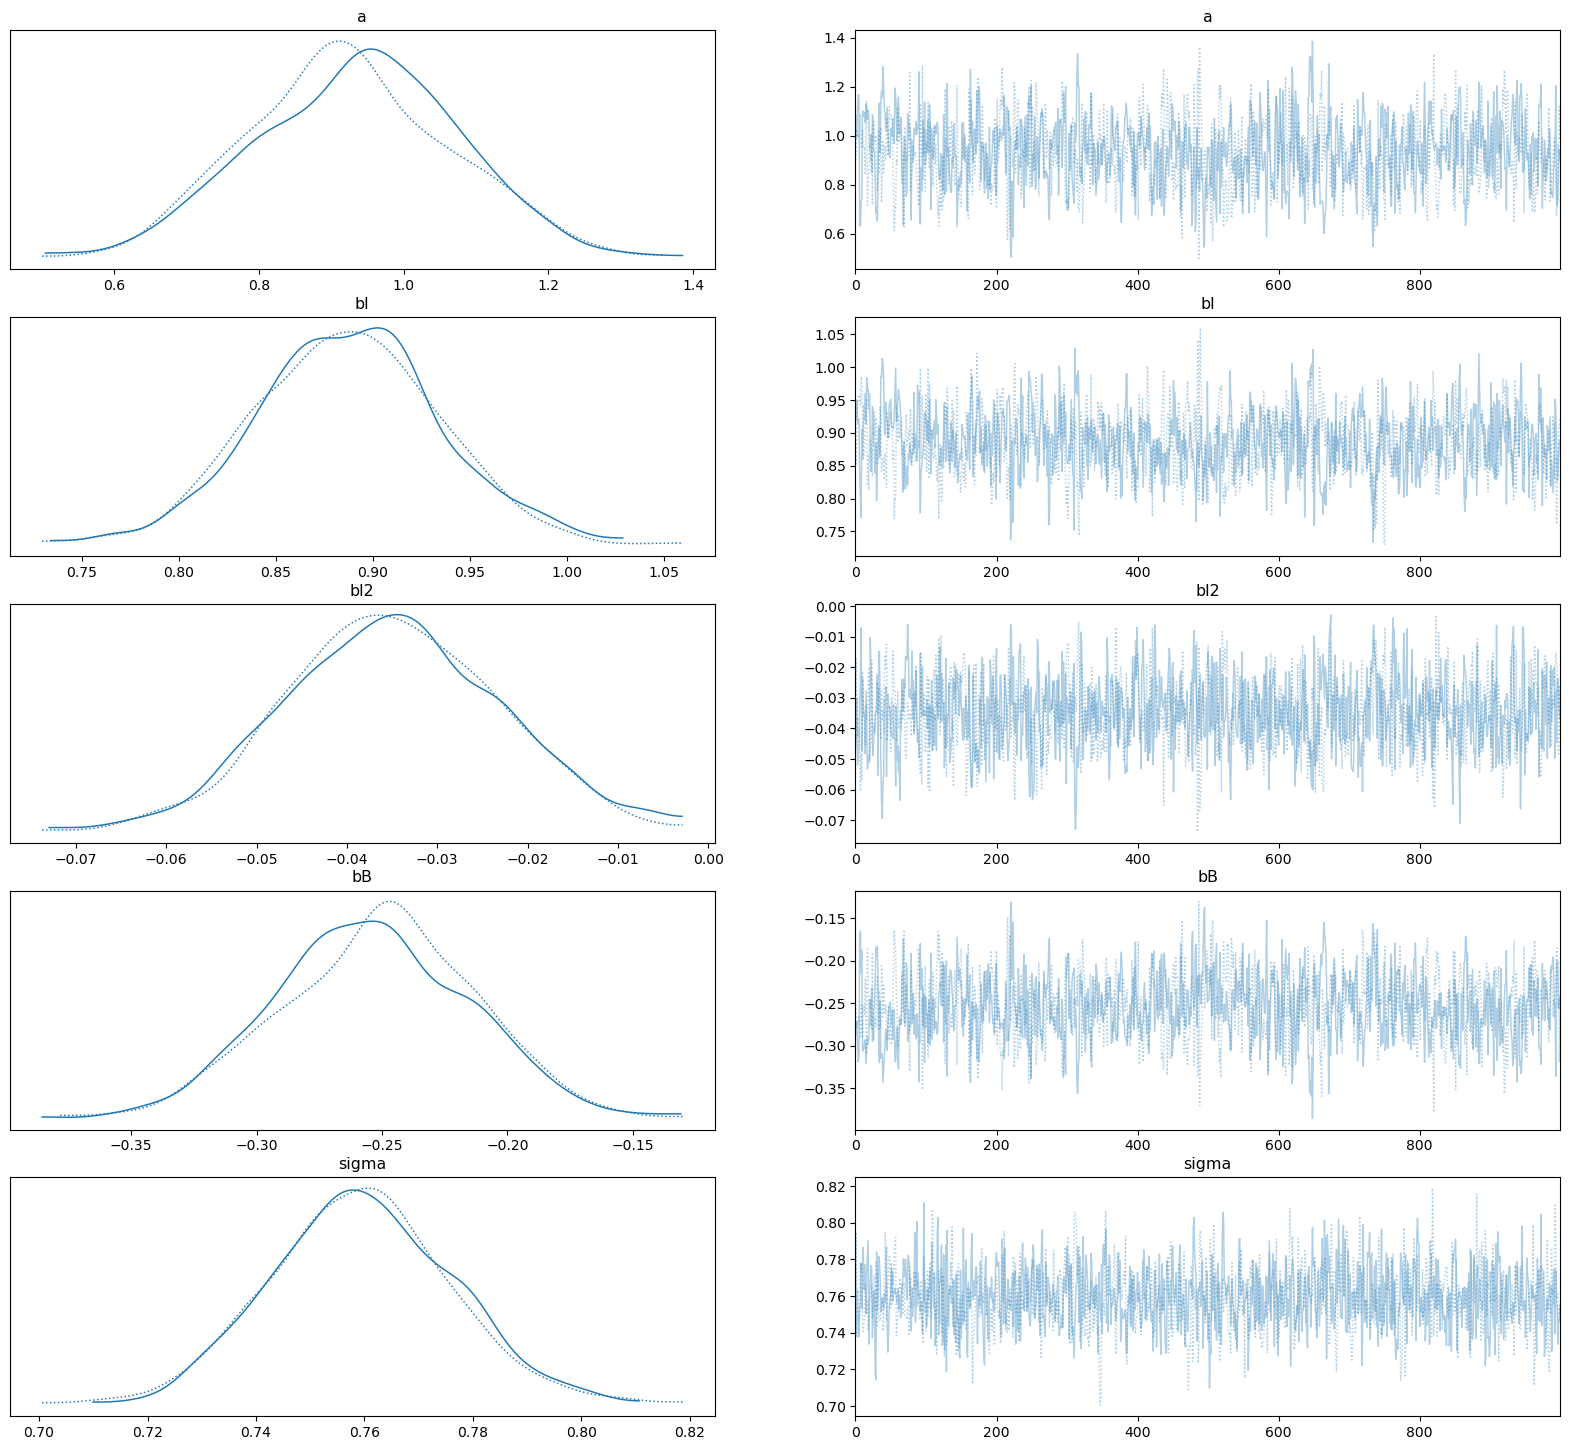

In [165]:
az.plot_trace(idata_direct_3, figsize=(20,18))

## Discussion

In conclusion, here's what we found throughout our project:

1. According to our DAG and our estimand, we expected to see a positive relationship between the total interior livable area and the listed price of a particular housing unit. This stayed true throughout our analysis and the results of multiple models reinforce that idea. The models that we ran all had significant positive values for the *bI* value.

2. Similarly, we expected that the number of bedrooms should be a confound variable that needs to be considered, as more bedrooms tend to be more living area, and more bedrooms would usually mean an increase in price as well. Interestingly, this is not actually the case, as we can see from multiple *bB* values, that according to our models, the number of bedrooms had little effect on the listed price, and a slightly inverse relationship at that.

3. This could be due to several reasons: First, consider the possible collinearity with the interior area variable. The two variables are highly correlated, and when both are included in the model, *I* might absorb much of the variance in the price that could be attributed to the *B* variable. This signifies an overlap in information as well since one variable convey some information about the other. However, *I* might, as we see in the summary of the plots above, provide a more continuous and precise measure compared to *B*, resulting in a more potent predictor.

4. From the perspective of the market, this negative coefficient for bedrooms might suggest a counter-intuitive relationship. This could be due to the fact that more bedrooms is associated with larger family homes, which could be in less central, and less desirable locations. Say for example, a big house in San Jose might be cheaper than a smaller house in San Francisco city. Since we are talking about markets, we have to think about these potential factors where buyers prioritize either on open space or how architects plan configurations over the number of rooms. It could also simply be that larger common areas and spacious designs could be more appealing than simply having more bedrooms.

5. This project has potential for further work, as the use of bedroom as a linear confound might be naive. Further analysis might require or be better with more predictors and more complicated models.

## Metrics

To evaluate and compare the performance of different models on unseen data, we use out-of-sample prediction error metrics. In this analysis, we specifically use the Leave-One-Out Cross-Validation (LOO) method calculated through Pareto-smoothed importance sampling (PSIS), a robust version of LOO.

The LOO metric, 'elpd_loo', estimates the expected log pointwise predictive density for a new dataset. This metric helps in comparing models: higher 'elpd_loo' values suggest better predictive performance. The 'p_loo' value represents the effective number of parameters, indicating model complexity where a higher 'p_loo' could imply overfitting.

The 'elpd_diff' shows the difference in 'elpd_loo' between models as a direct comparison — a model with an 'elpd_diff' of zero is the reference model, and positive values in others suggest worse performance. 'Weight' gives an idea of the relative probability of each model given the data; a weight close to 1 indicates a clearly preferable model.

Here's how the models stack up based on these metrics:

- The 'Poly' model shows a higher LOO score (better predictive accuracy) and a lower 'p_loo' than the 'StudentT' model, suggesting it might be more effective and less complex.
- Despite 'StudentT' having a higher complexity (p_loo), its predictive performance as per 'elpd_loo' is lower than the 'Poly', and it receives almost no weight in model comparison, indicating the 'Poly' model is strongly favored.

These insights are critical for selecting models based on their ability to generalize well to new data without overfitting.

In [166]:
model_dict = {
    "StudentT": idata_direct_2,
    "Poly": idata_direct_3
}

In [167]:
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
compare_df_psis

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Poly,0,2211.475113,5.437892,0.000000,1.000000e+00,41.058115,0.000000,False,deviance
StudentT,1,2223.643506,4.567864,12.168394,2.664535e-14,41.947145,7.684739,False,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


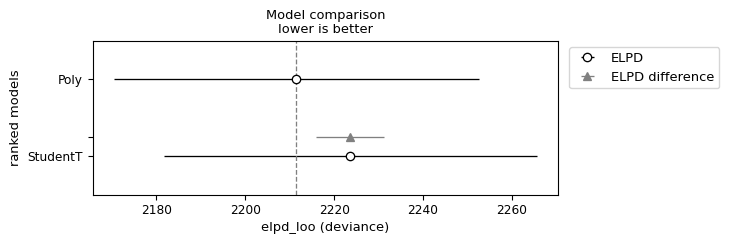

In [168]:
_ = az.plot_compare(compare_df_psis)